### GANs: Generative Adverserial Networks 
GANs are used to create new data given a training set. A generator network and discriminator network try to fool one another in a two-player game. The generator network generates fake data and a discriminator network classifies data which is fake. The generator network tries to fool the discriminator network and the discriminator network learns to NOT get fooled by the generator network. Overtime, both get better and better. We then use the trained generator network to create new data! 
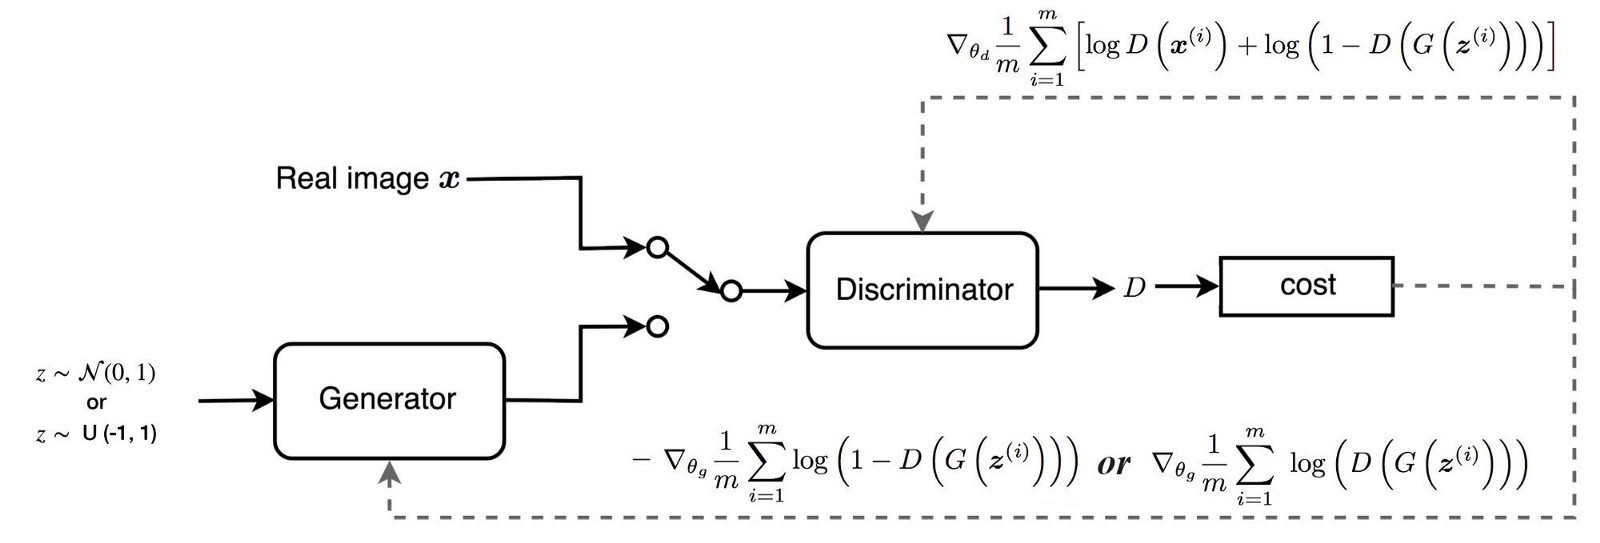
GANs were introduced in the 2014 paper titled "Generative Adverserial Nets" (Goodfellow et al.)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import imageio
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import normalize
from tensorflow.keras import Sequential, layers, losses, optimizers
from tqdm import tqdm

### Loss function and optimizer

In [2]:
celoss = losses.BinaryCrossentropy(from_logits=True)
genopt = optimizers.Adam(3e-4)
discopt = optimizers.Adam(3e-4)

In [7]:
epochs, ndim, bsize, bfsize = 50, 100, 250, 60000

### Generator network 

In [3]:
def genmodel():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7 * 7 * 128, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 128)))
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

### Discriminator network

In [4]:
def discmodel():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (5, 5), padding='same', input_shape=[28, 28, 1], kernel_initializer='he_uniform'))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

### Generator and discriminator loss

In [5]:
def genloss(fakepred):
    return celoss(tf.ones_like(fakepred), fakepred)

In [6]:
def discloss(realpred, fakepred):
    return celoss(tf.ones_like(realpred), realpred) + celoss(tf.zeros_like(fakepred), fakepred)

### Initialize and train model

In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(bfsize).batch(bsize)

In [9]:
generator, discriminator = genmodel(), discmodel()

In [10]:
def step(images):
    noise = tf.random.normal([bsize, ndim])

    with tf.GradientTape() as gentape, tf.GradientTape() as disctape:
        gen = generator(noise, training=True)

        realpred = discriminator(images, training=True)
        fakepred = discriminator(gen, training=True)

        gloss = genloss(fakepred)
        dloss = discloss(realpred, fakepred)

    gengrad = gentape.gradient(gloss, generator.trainable_variables)
    discgrad = disctape.gradient(dloss, discriminator.trainable_variables)

    genopt.apply_gradients(zip(gengrad, generator.trainable_variables))
    discopt.apply_gradients(zip(discgrad, discriminator.trainable_variables))

In [11]:
noises = tf.random.normal([25, 100])
def train(dataset, epochs):
    for epoch in tqdm(range(epochs)):
        for batch in dataset:
            step(batch)
        genimages = generator(noises, training=False)
        images = [np.reshape(im, (28, 28)) for im in genimages]
        fig = plt.figure(figsize=(10, 10))
        for _ in range(25):
            plt.subplot(5, 5, _ + 1)
            plt.imshow(images[_])
            plt.axis('off')
        plt.savefig(f'mnistgan{epoch}.png')

 40%|██████████████████████████████▊                                              | 20/50 [3:12:48<4:49:22, 578.74s/it]<ipython-input-11-b94c85e392da>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10, 10))
100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [8:04:16<00:00, 581.14s/it]


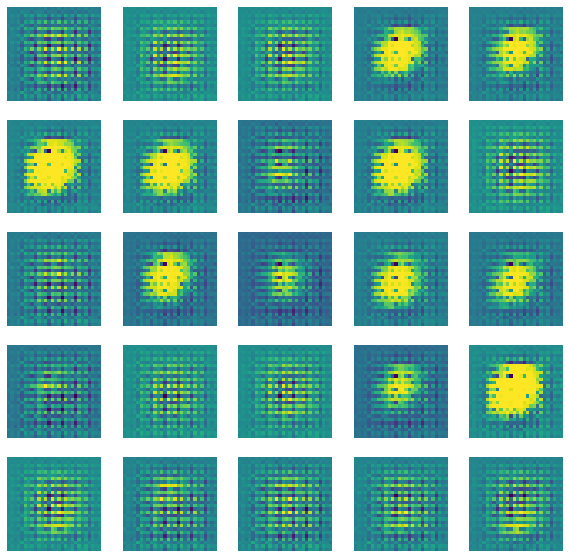

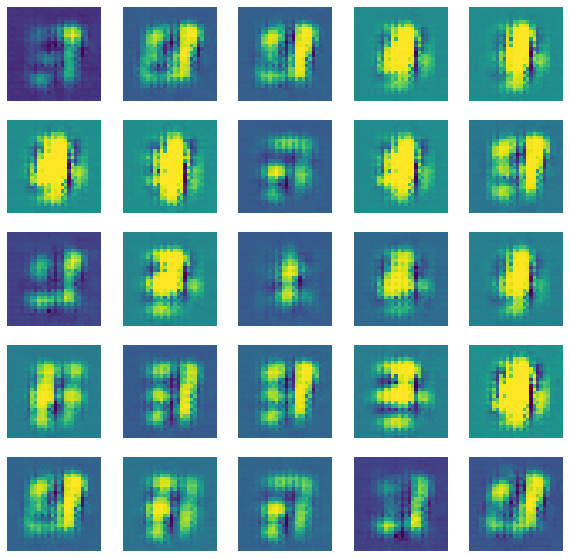

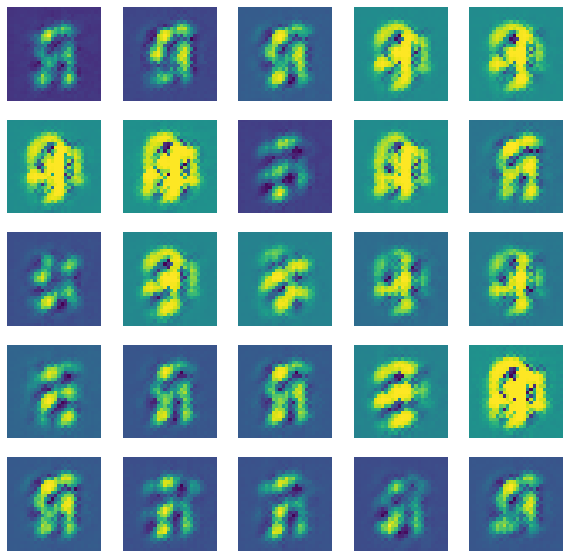

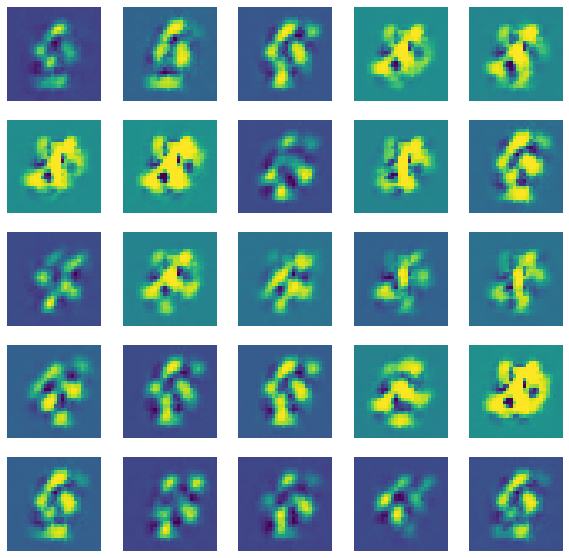

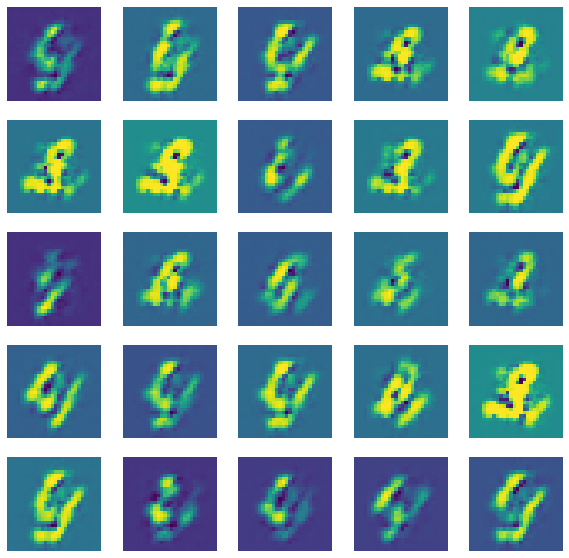

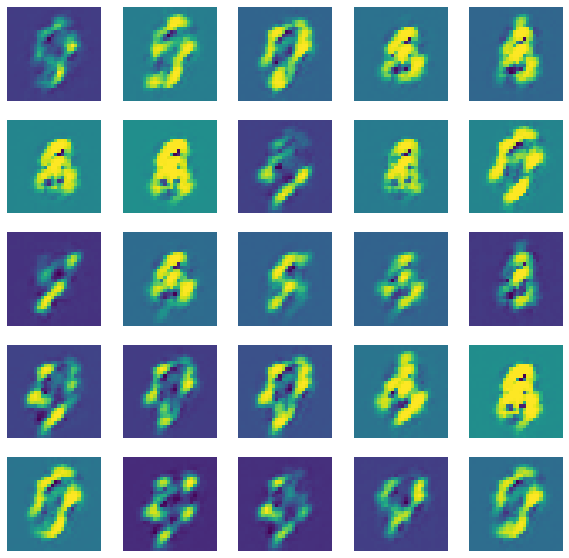

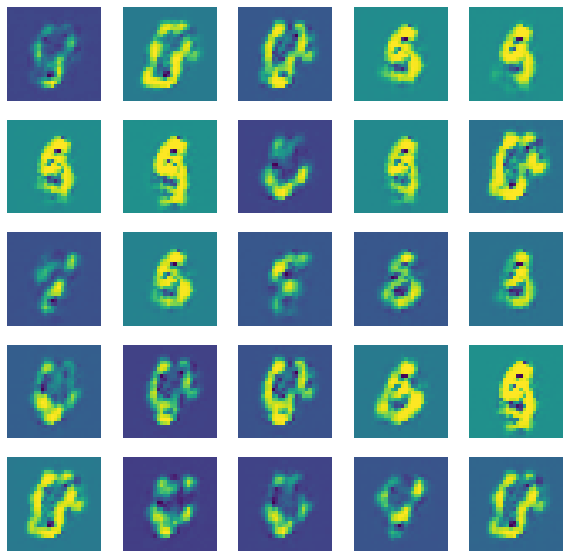

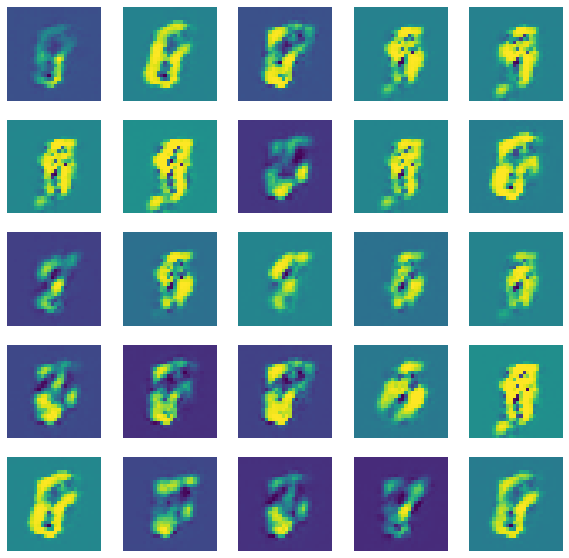

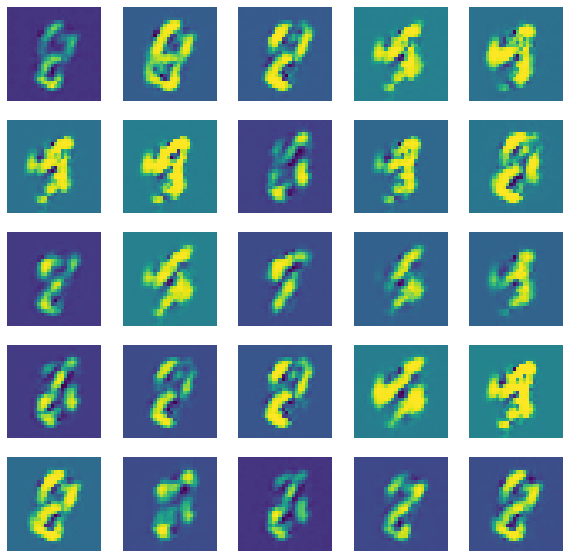

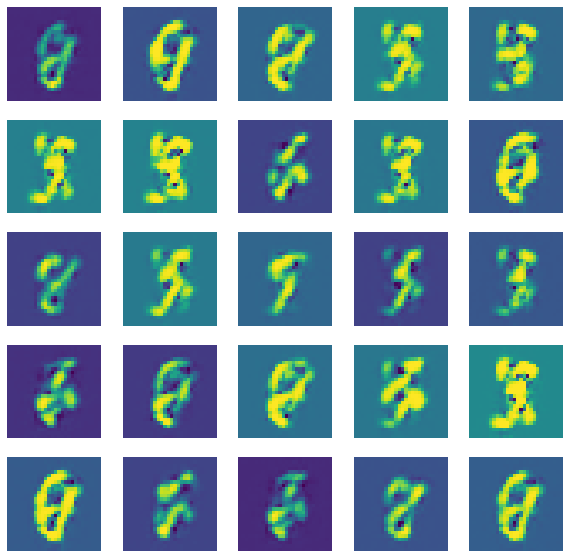

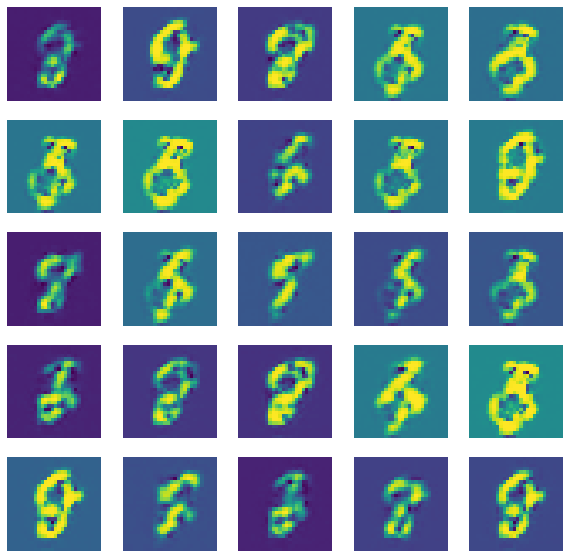

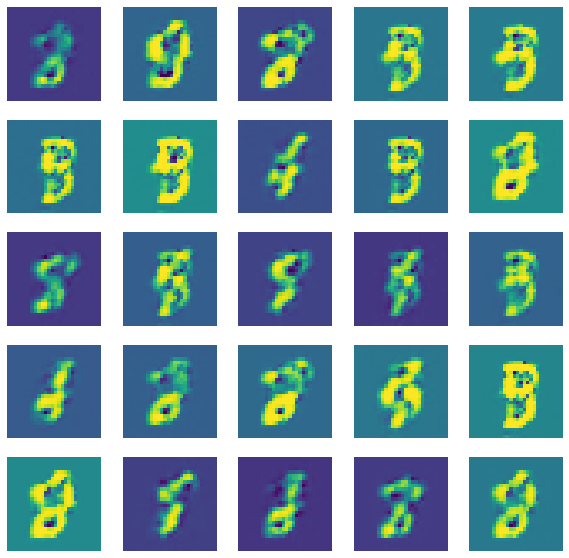

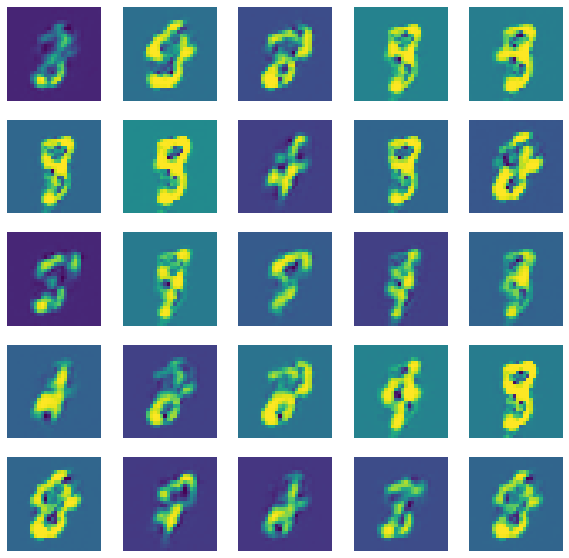

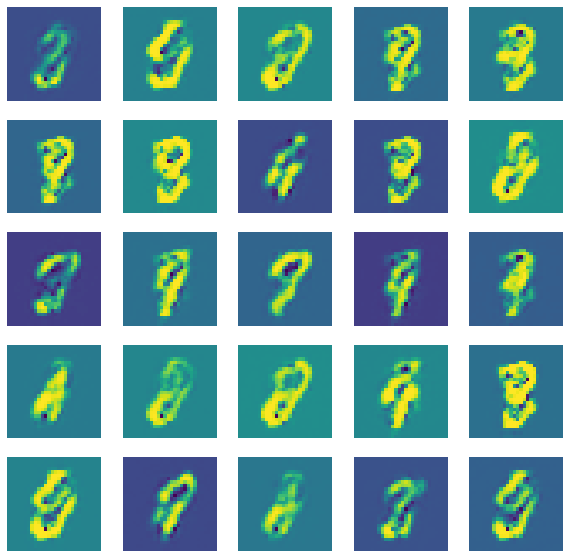

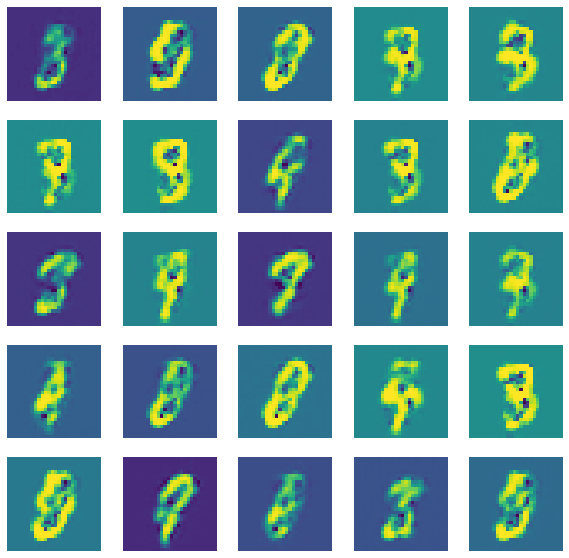

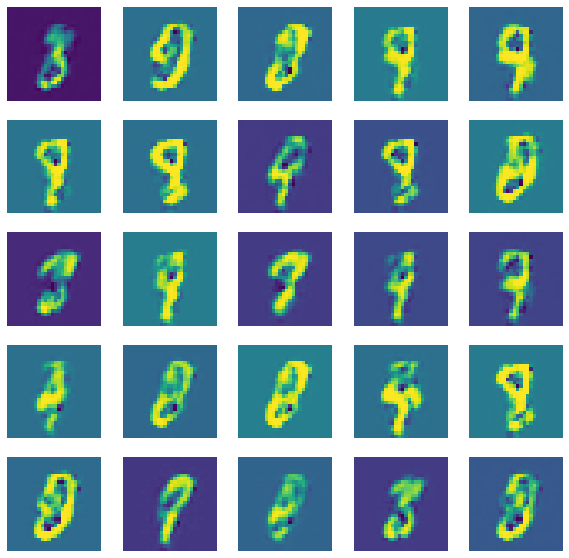

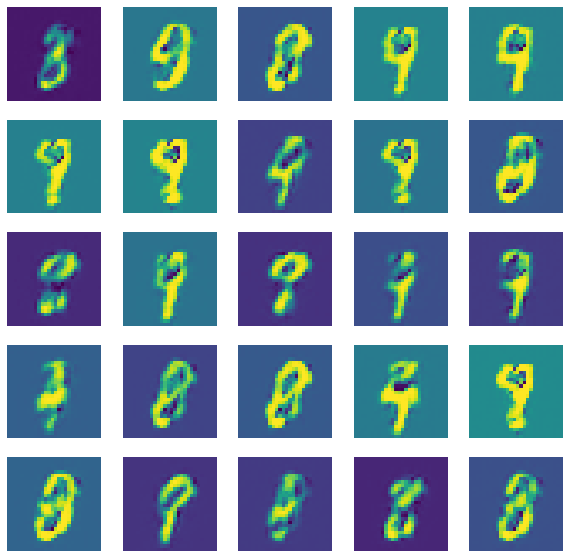

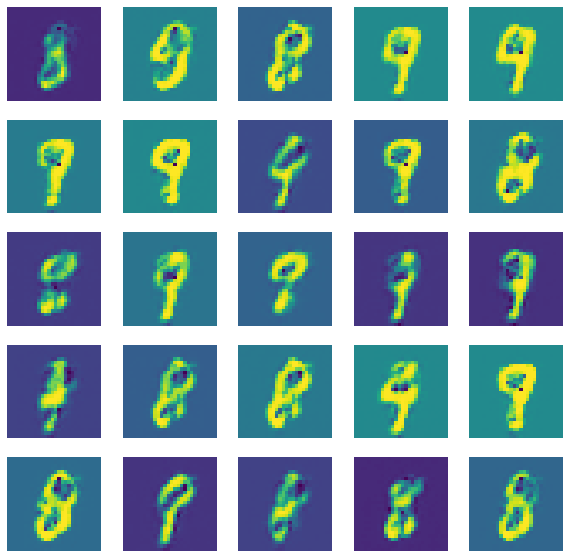

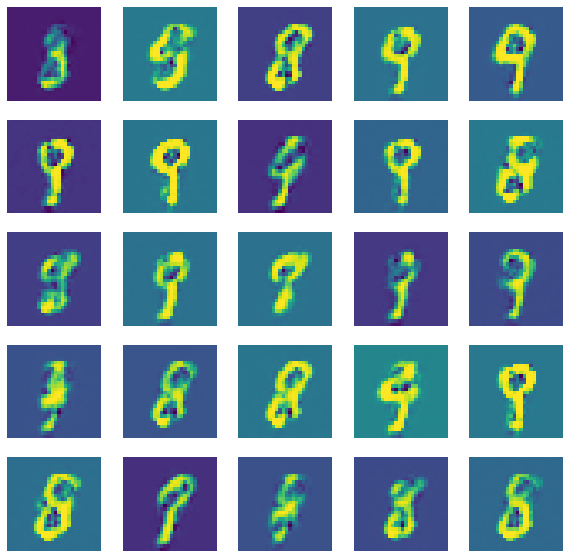

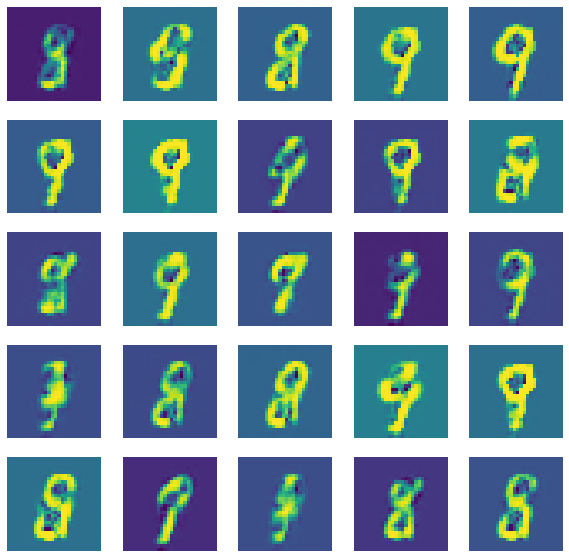

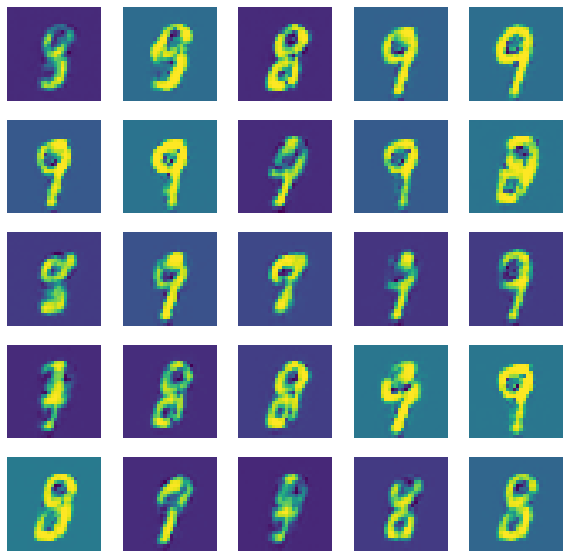

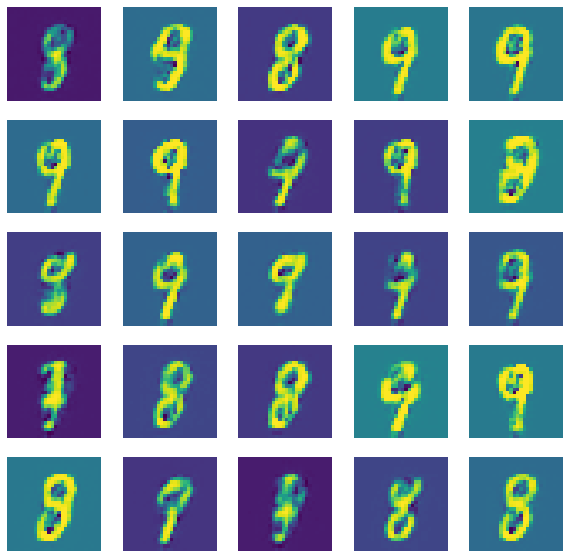

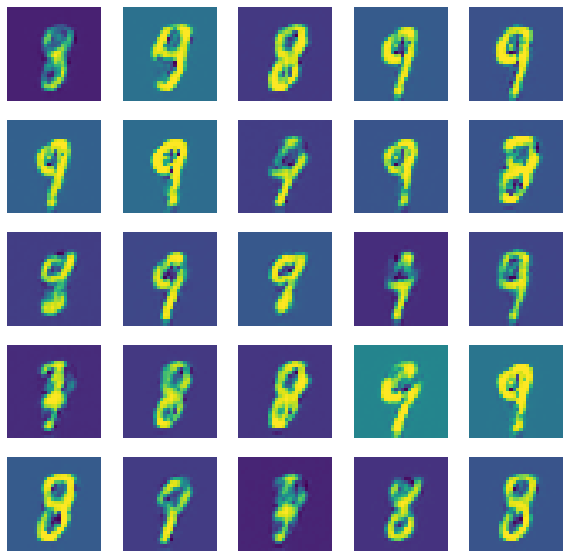

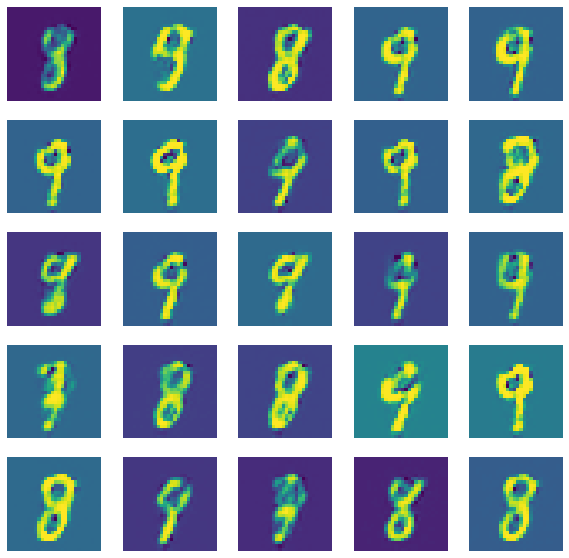

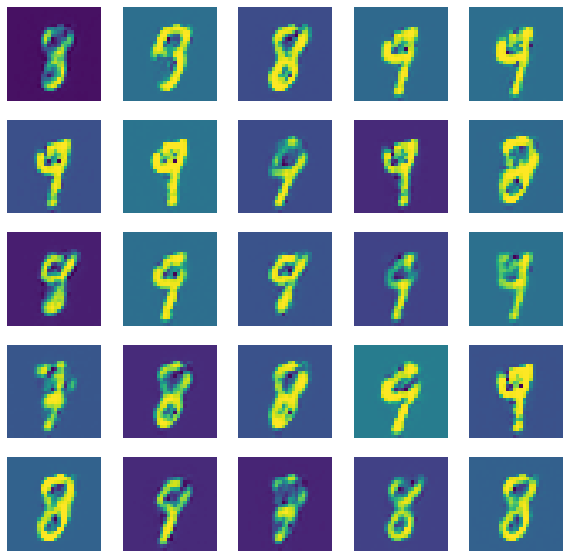

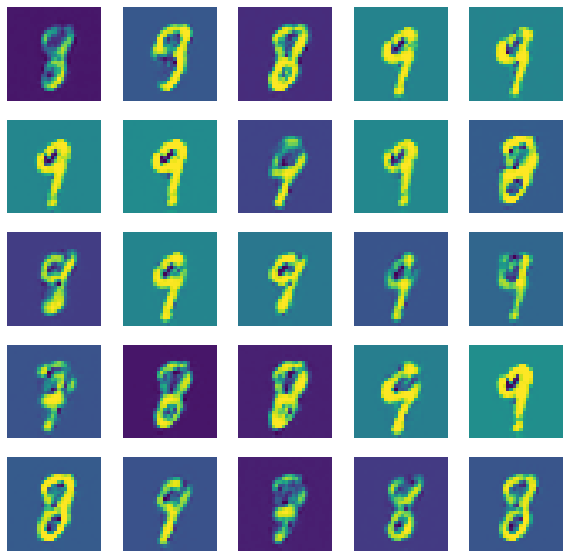

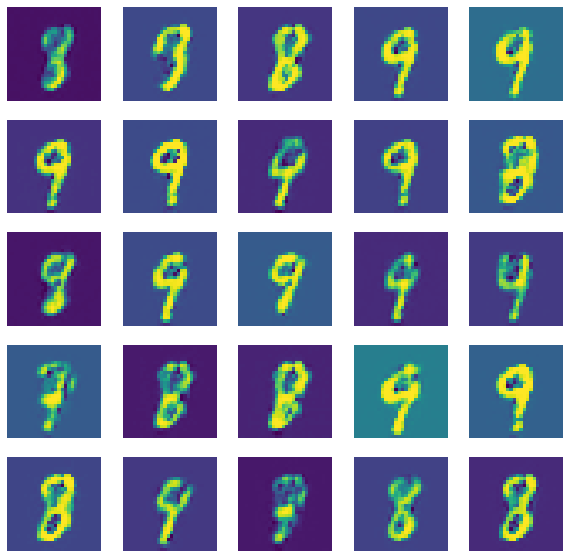

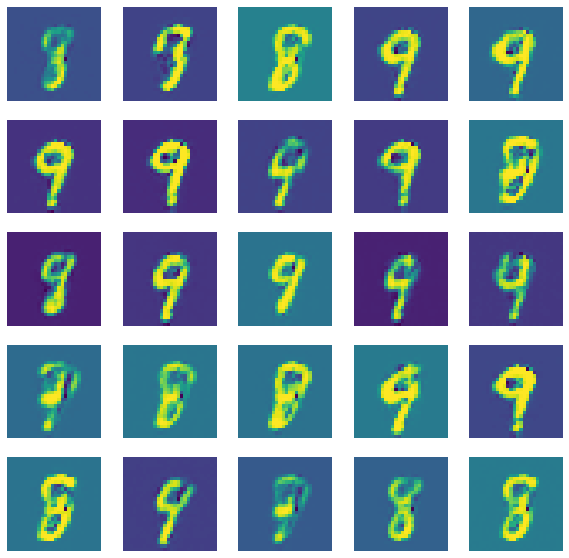

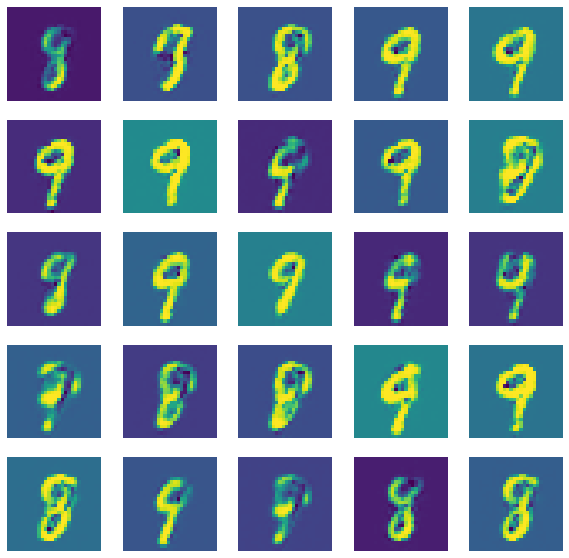

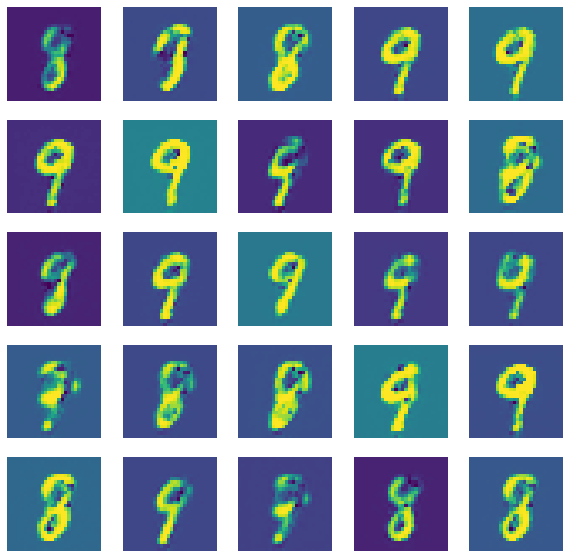

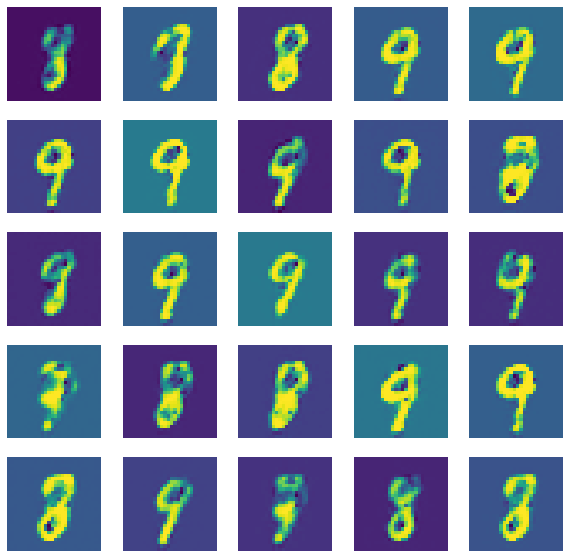

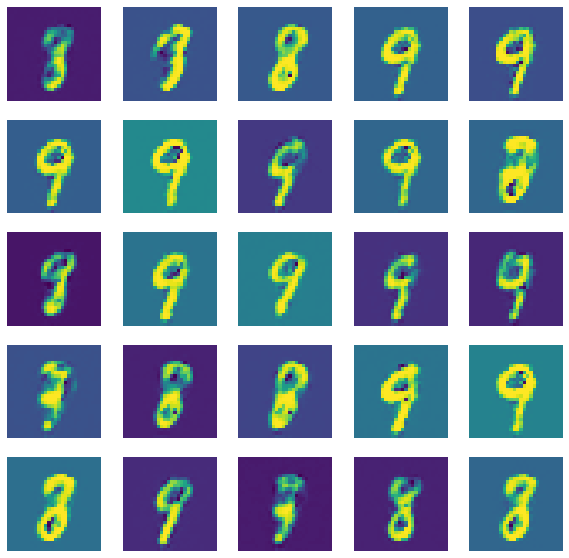

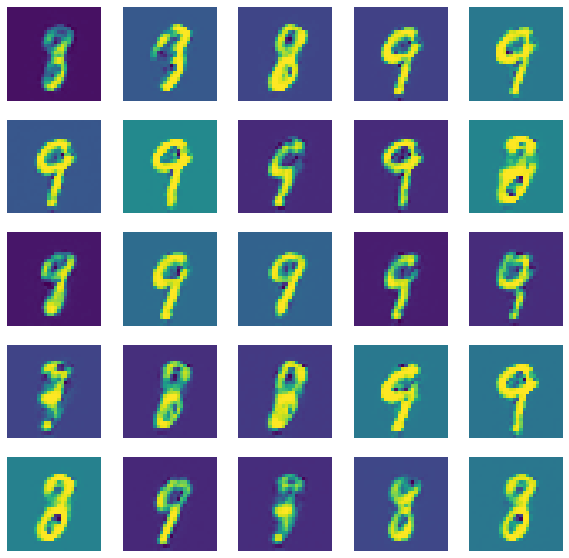

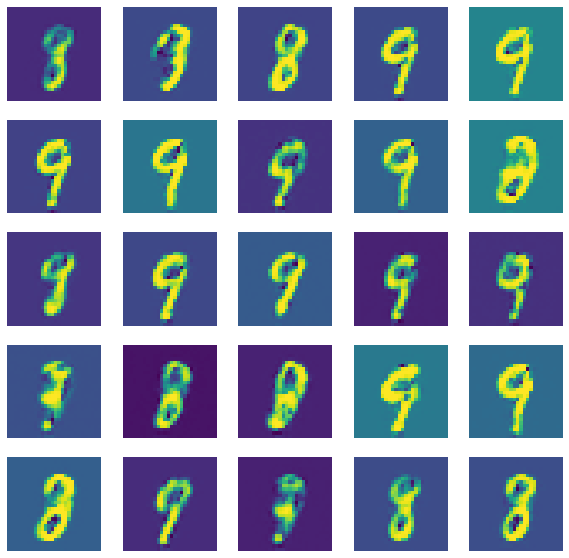

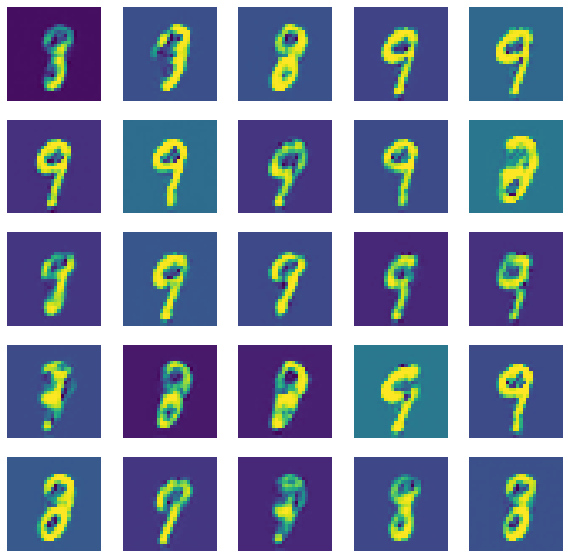

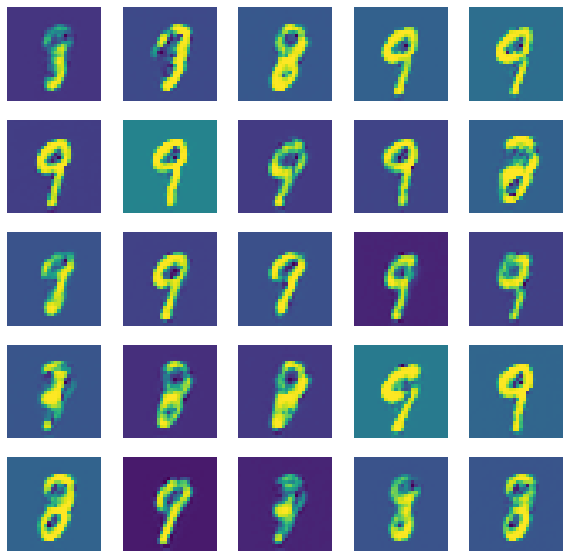

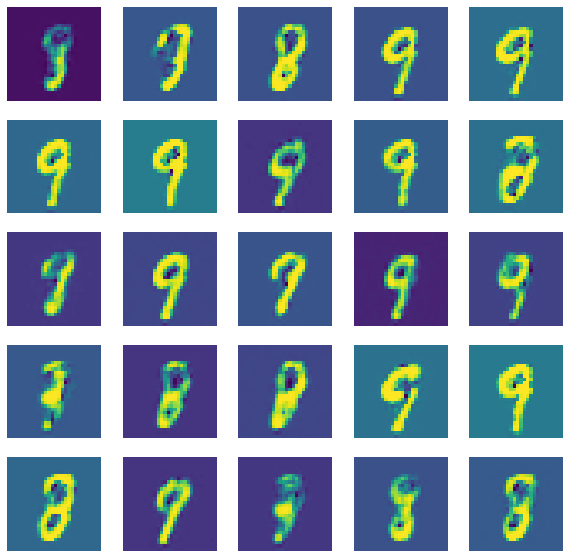

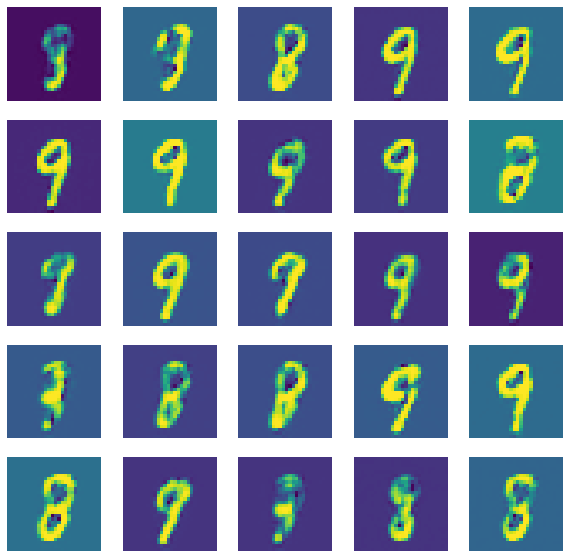

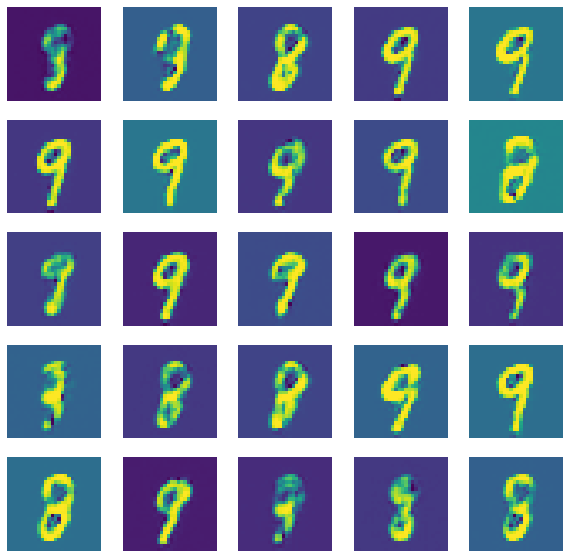

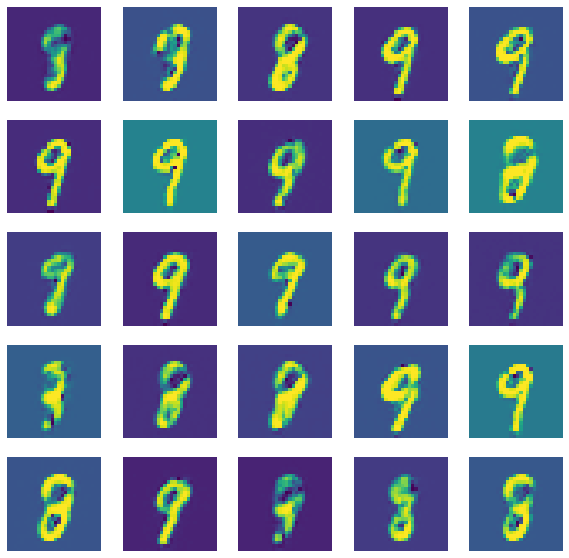

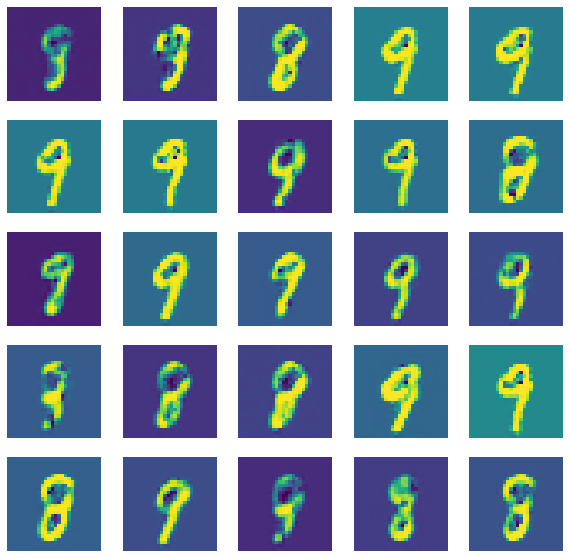

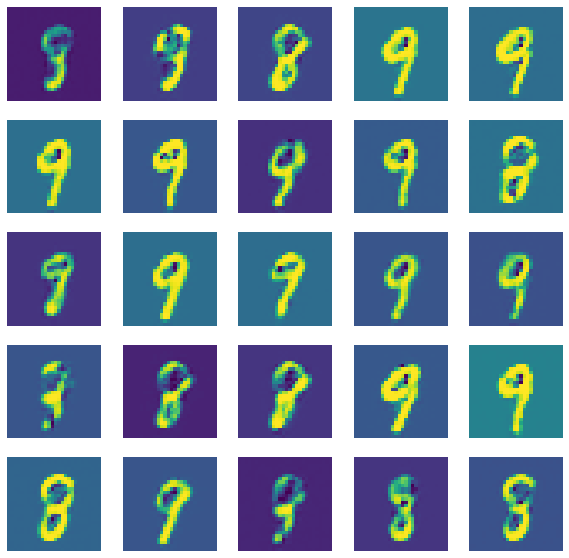

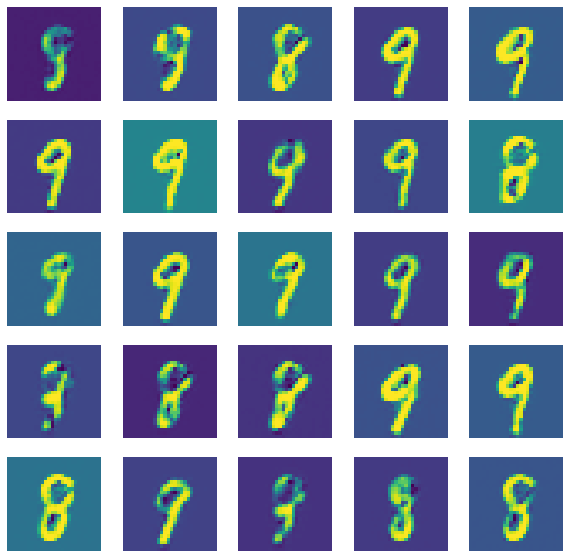

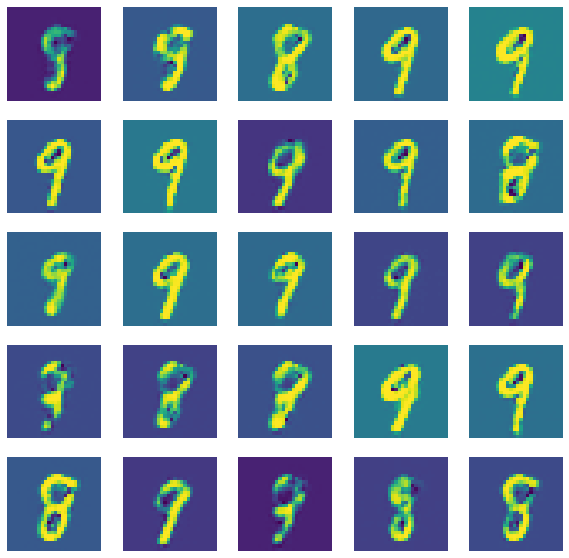

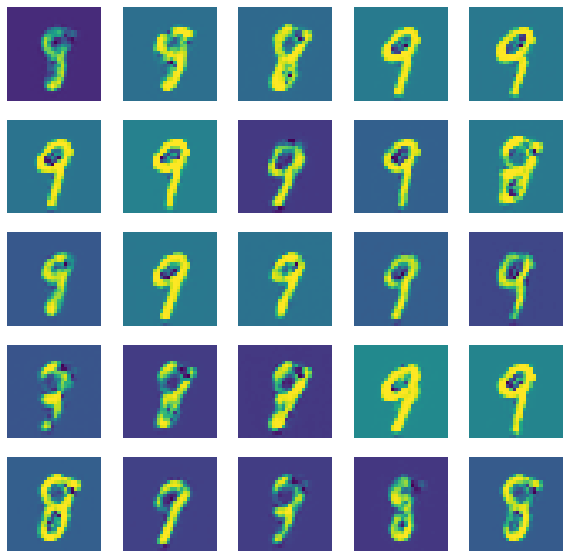

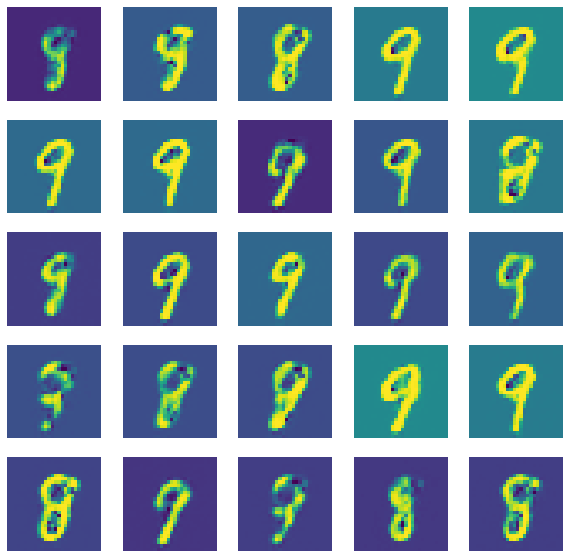

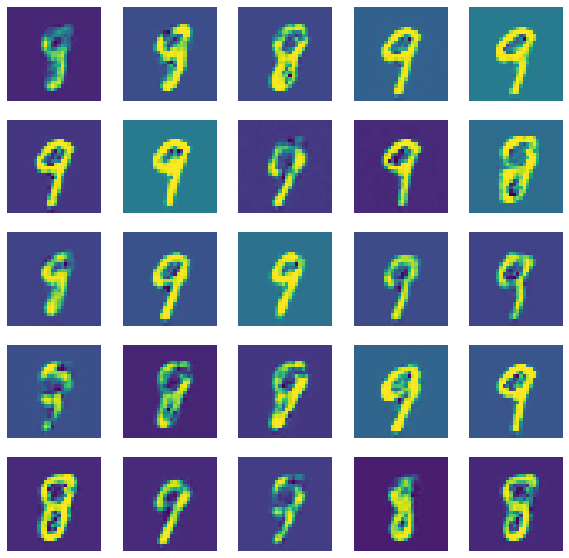

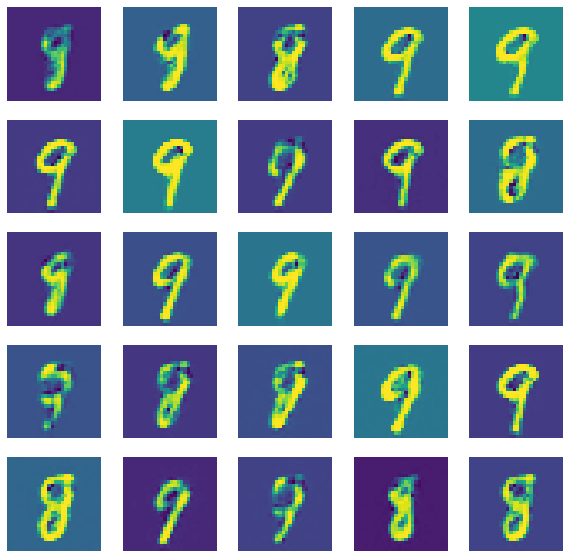

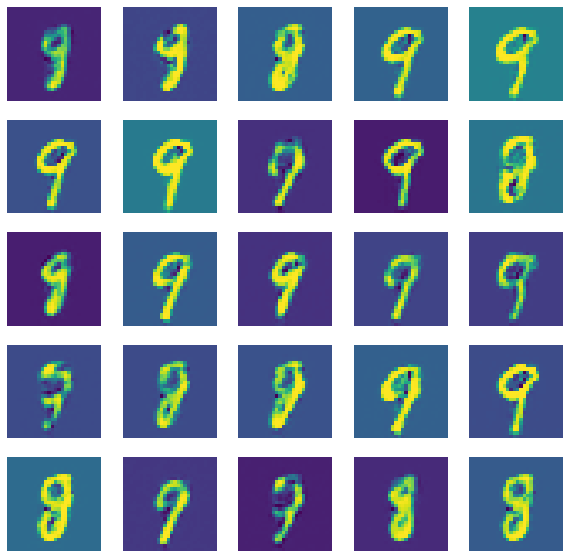

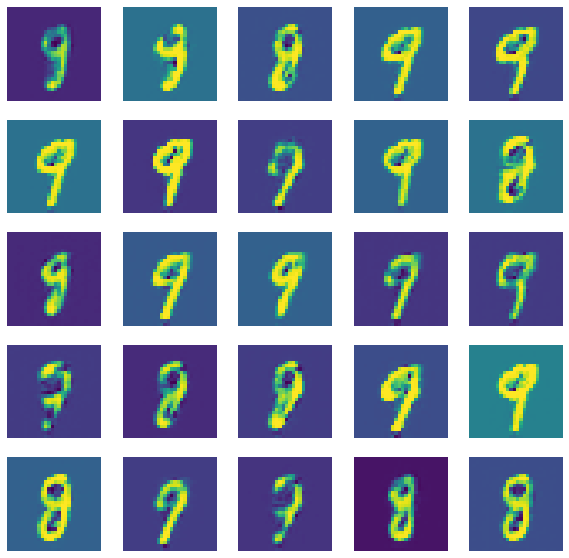

In [12]:
train(dataset, epochs)

### Result
I've combined the above images to make a GIF. We use the same set of noises to generate the images. It's really awesome to see how we can go from noise to recognizable images using a relatively simple algorithm. Here, we don't actually use the loss function in the GAN algorithm directly. We compute loss using fake labels (vectors of ones and zeros) and compute gradients using tf.GradientTape(). The output of the discriminator is going to be single number in the range $[0, 1]$. We compute it using $D(I)$ where $D$ is the discriminator network and $I$ can either be a real image $x\in dataset$ or a fake image $G(\epsilon)$ where $G$ is the generator network and $\epsilon$ is some noise vector (gaussian prior) we feed in as input. We use cross entropy loss for both networks. For the discriminator, the loss function is $L_d=-\frac{1}{m}\sum_{i=0}^my_ilog(D(I))+(1-y_i)log(1-D(I))$ where $m$ is the batch size. For the generator, the loss function is cross entropy as well, but since all the labels equal to 1, the loss function simplifies to $L_g=-\frac{1}{m}\sum_{i=0}^mlog(D(G(\epsilon_i)))$. It took about 8 hours to complete 50 epochs. 